In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

import sys
sys.path.insert(0,'../src/')

from utils import *
from multiply_connected_pipe import *
from pipe_system import PipeSystem
from abstract_pipe import *

In [2]:
# with open('pipes_and_shifts.pickle','rb') as f:
#     pipes, shifts = pickle.load(f)
with open('pipes_and_shifts_built.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

In [3]:
bdr_pipe = BoundaryPipe([BoundaryLet(-5,0,0,1,-1),BoundaryLet(31,0,np.pi,1,1)])
real_pipes = [RealPipe(p,shift_x=shift[0],shift_y=shift[1]) for p,shift in zip(pipes,shifts)]
lets = sorted([l for p in real_pipes for l in p.lets], key=lambda l: l.x)
lets[0], lets[-1]

(Let(x=-5.0, y=0.0, dir=3.141592653589793, dia=1.0),
 Let(x=31.0, y=0.0, dir=0.0, dia=1.0))

In [4]:
ps = PipeSystem(real_pipes,bdr_pipe)

In [8]:
[l.matching_pt for l in pipes[0].lets]

[array([-5.,  0.]), array([13., -6.]), array([13.,  6.])]

In [9]:
[l.matching_pt for l in pipes[1].lets]

[array([13., -6.]), array([31.,  0.]), array([13.,  6.])]

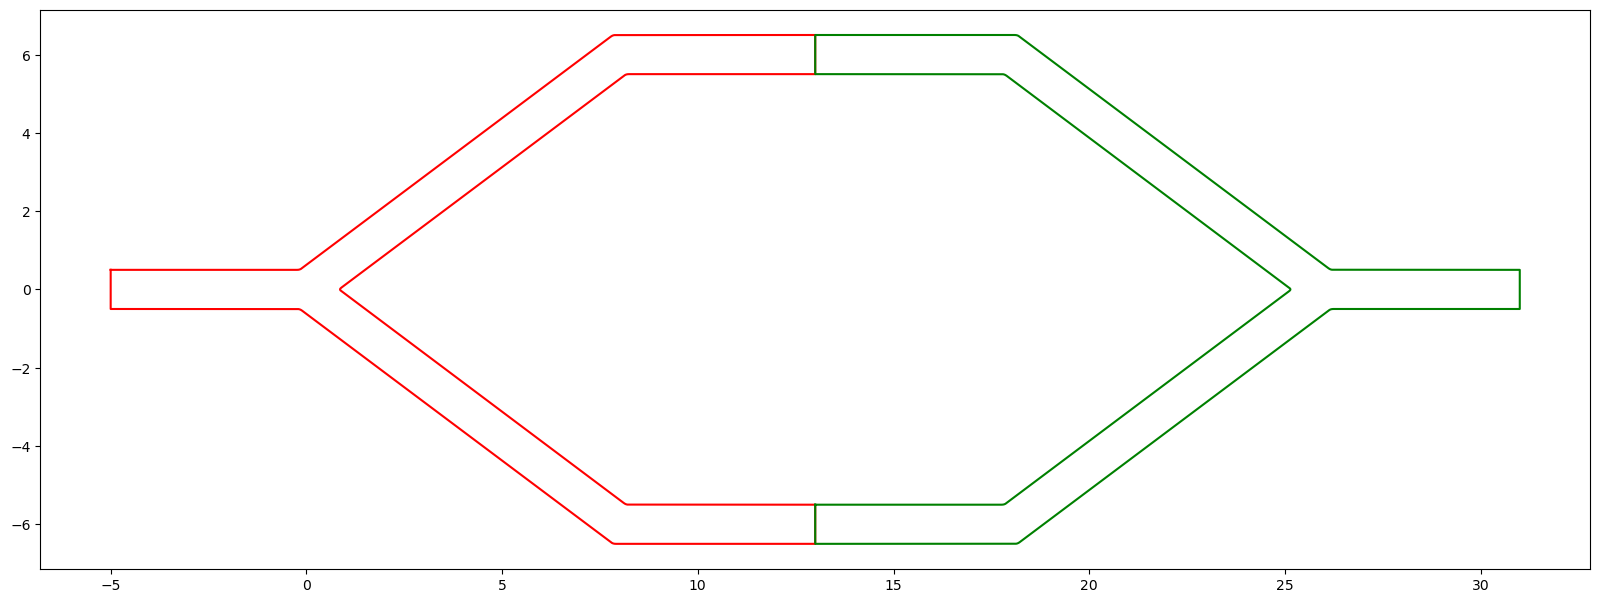

In [13]:
color = 'rg'

fig,ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(10),pipes,shifts,color):
    ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,c=c)
    
    # for k,let in enumerate(i.lets):
    #     ax.text(*(0.6*let.matching_pt + j),f'{k},{let.matching_pt + j}',color=c)
    # ax.text(*j,f'{a}, {j}',color=c)

In [14]:
xs, ys, u_field, v_field, p_field, o_field = ps.plotting_data()

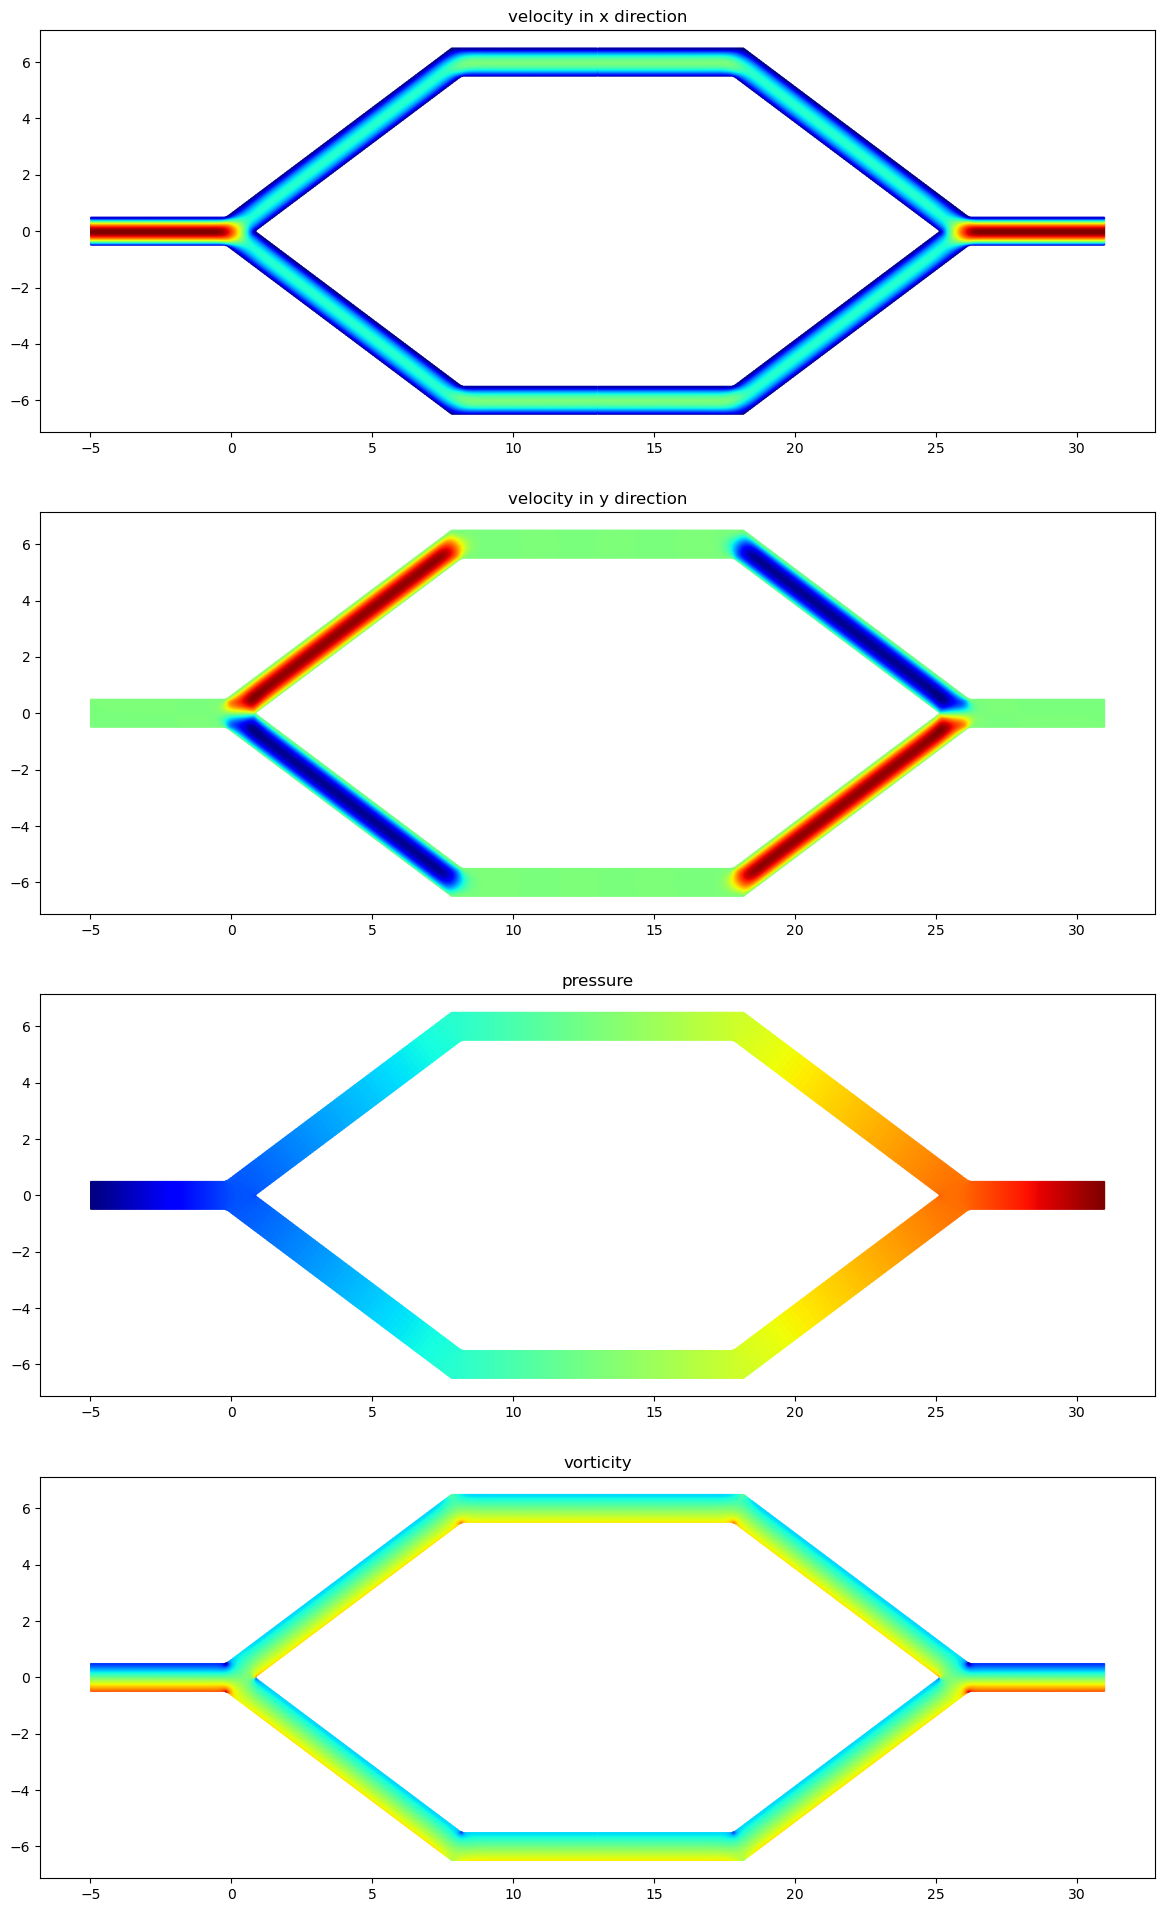

In [15]:
fig,axes = plt.subplots(4,1,figsize=(20,24))

for ax, field, title, in zip(axes, [u_field,v_field,p_field,o_field], ['velocity in x direction','velocity in y direction','pressure','vorticity']):
    ax.set_aspect('equal')
    ax.scatter(xs,ys,c=field,s=0.1,cmap='jet',)
    
    ax.set_title(title)
    # for a,i,j in zip(range(10),pipes,shifts):
    #     panel_break_pts = np.array([cplx2pt(p.start_pt) + j for p in i.panels])
    #     ax.scatter(panel_break_pts[:,0], panel_break_pts[:,1],c='black',s=1,marker='x')

In [17]:
with open('global_pipe_built.pickle','rb') as f:
    global_pipe = pickle.load(f)

In [19]:
for p in global_pipe.panels: p._build()

In [20]:
velocity = global_pipe.velocity(xs,ys,global_pipe.omegas[0])
pressure, vorticity = global_pipe.pressure_and_vorticity(xs,ys,global_pipe.omegas[0])
offset = np.quantile(pressure-p_field,.5)
pressure -= offset

/home/haiy/pkg/fmm2d/python/fmm2dpy/fmm2d.py:894: ComplexWarning: Casting complex values to real discards the imaginary part
  out.pottarg,out.gradtarg,out.ier = lfmm.cfmm2d_t_d_g(eps,sources,dipstr,targets)


In [26]:
p_diff = np.log10(np.abs(pressure-p_field))
o_diff = np.log10(np.abs(vorticity-o_field))
u_diff = np.log10(np.linalg.norm(np.array([u_field,v_field]) - velocity.T,axis=0))

vmax = np.max(np.array([p_diff,o_diff,u_diff]))
vmin = max(np.min(np.array([p_diff,o_diff,u_diff])),-20)

/tmp/ipykernel_7353/2447502227.py:1: RuntimeWarning: divide by zero encountered in log10
  p_diff = np.log10(np.abs(pressure-p_field))


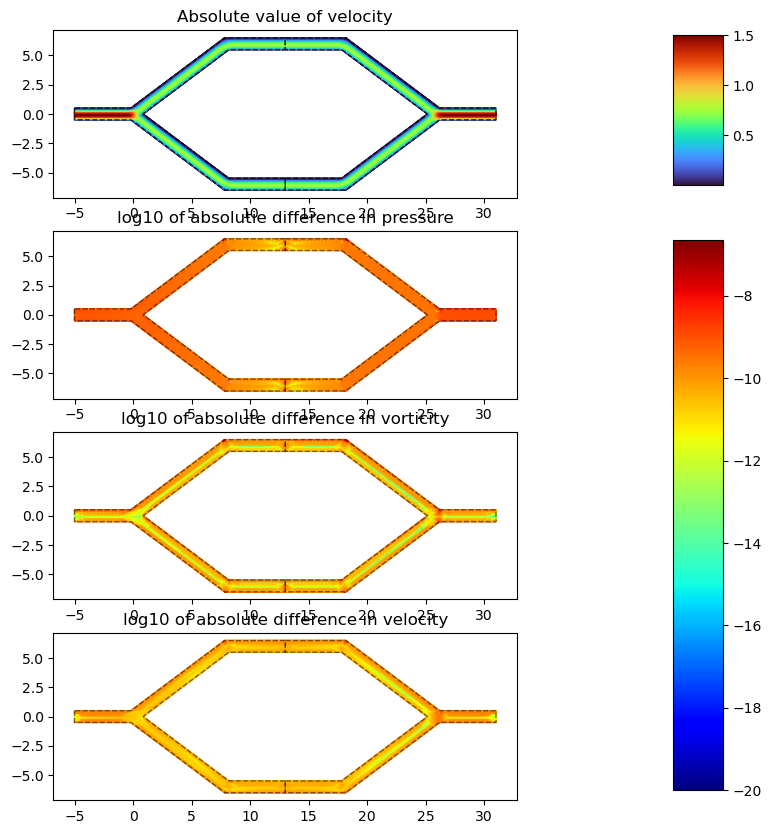

In [30]:
fig, axes = plt.subplots(4,1,figsize=(10,10))

ax = axes[0]
ax.set_aspect('equal')
im1 = ax.scatter(xs,ys,c=np.linalg.norm(np.array([u_field,v_field]),axis=0),s=0.1, cmap='turbo')
ax.set_title("Absolute value of velocity")

for a,i,j in zip(range(22),pipes,shifts):
    ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,'--k',alpha=0.8,linewidth=1)
    
for ax, diff, title in zip(axes[1:], [p_diff, o_diff, u_diff], ['log10 of absolutie difference in pressure', 'log10 of absolute difference in vorticity', 'log10 of absolute difference in velocity']):
    ax.set_aspect('equal')
    im = ax.scatter(xs,ys,c=diff,s=0.1, vmin=vmin,vmax=vmax,cmap='jet')
    ax.set_title(title)
    
    for a,i,j in zip(range(22),pipes,shifts):
        ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,'--k',alpha=0.5,linewidth=1)
    

fig.subplots_adjust(right=0.8)
cbar_ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.55])
fig.colorbar(im, cax=cbar_ax2)
cbar_ax1 = fig.add_axes([0.85, 0.725, 0.05, 0.15])
fig.colorbar(im1, cax=cbar_ax1)